In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def generate_pikachu_coutour(max_radius=1.2):
    
    # Load the silhouette image
    image_path = "mask_sample_1.png"
    # Flip the mask label
    image = 255-cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Threshold the image to obtain a binary image
    _, binary_image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)

    # Find contours in the binary image
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


    x = np.float32(contours[0][::-1, :, 0].flatten())
    y = np.float32(contours[0][::-1, :, 1].flatten())
    x -= np.mean(x)
    y -= np.mean(y)
    scale = max_radius / np.maximum(np.max(np.abs(x)), np.max(np.abs(y)))
    x *= scale
    y *= -scale
    return x, y

def generate_heart_contour(num_points=100, max_radius=1.2):
    """
    Generate a heart-shaped contour centered at the origin with a maximum radius not exceeding max_radius.
    
    Parameters:
    - num_points: Number of points in the contour.
    - max_radius: Maximum radius of the heart shape.
    
    Returns:
    - x, y: Coordinates of the heart-shaped contour.
    """
    # Generate an array of angles from 0 to 2π
    theta = np.linspace(0, 2 * np.pi, num_points)
    
    # Original heart shape in polar coordinates
    r = 1 - np.sin(theta)
    
    # Scale the radius to ensure the maximum radius is max_radius
    scaling_factor = max_radius / np.max(r)
    r = r * scaling_factor
    
    # Convert polar coordinates to Cartesian coordinates
    x = r * np.cos(theta)
    y = r * np.sin(theta) + max_radius / 2
    
    return x, y

def generate_camera_trajectory(num_points=20, radius_min=1.5, radius_max=2, oscillations=2, fov=np.pi/2):
    """
    Generate a closed continuous 2D camera trajectory storing location, lookat vector, and FOV.
    
    Parameters:
    - num_points: Number of points in the trajectory.
    - radius_min: Minimum radius from the origin.
    - radius_max: Maximum radius from the origin.
    - oscillations: Number of oscillations in the radial direction.
    - fov: Field of view in radians.
    
    Returns:
    - cameras: A structured array with 'position', 'lookat', and 'fov' for each camera.
    """
    # Generate angles for the camera trajectory and radii for positions
    angles = np.linspace(0, 2 * np.pi, num_points)
    radii = radius_min + (radius_max - radius_min) * 0.5 * (1 + np.sin(oscillations * angles))
    
    # Compute camera positions in Cartesian coordinates
    x = radii * np.cos(angles)
    y = radii * np.sin(angles)
    positions = np.column_stack((x, y))  # Shape: (num_points, 2)
    
    # Compute look-at vectors (pointing to the origin)
    lookat_vectors = -positions / np.linalg.norm(positions, axis=1)[:, np.newaxis]
    
    # Create the output structured array
    cameras = np.zeros(num_points, dtype=[('position', float, 2), ('lookat', float, 2), ('fov', float)])
    cameras['position'] = positions
    cameras['lookat'] = lookat_vectors
    cameras['fov'] = fov  # Assign the same FOV for all cameras
    
    return cameras


def plot_camera_trajectory_with_FOV(trajectory, origin=(0, 0), FOV = np.pi / 2, sensor_size=0.2):
    """
    Plot the camera trajectory with isosceles triangles representing the camera's field of view.
    
    Parameters:
    - trajectory: A NumPy array of shape (num_points, 2) representing the (x, y) camera positions.
    - origin: The point the camera is looking at (default is (0, 0)).
    - focal_length: The focal length of the camera.
    - sensor_size: The size of the camera's sensor.
    """
    
    # plt.figure(figsize=(6, 6))
    
    # Plot the camera trajectory
    plt.plot(trajectory[:, 0], trajectory[:, 1], label="Camera Trajectory", linestyle='--', color='gray')
    
    # Plot the origin (the camera's look-at target)
    plt.scatter([origin[0]], [origin[1]], color='red', label="Origin (Camera Target)", zorder=5)
    
    # Plot the camera FOV for each point
    for position in trajectory:
        lookat_vector = np.array(origin) - position  # Look-at vector pointing to the origin
        lookat_direction = lookat_vector / np.linalg.norm(lookat_vector)  # Normalize
        
        # Compute the two sides of the isosceles triangle (camera's FOV)
        half_angle = FOV / 2
        base_length = sensor_size  # The length of the imaging plane's base
        
        # Rotate the lookat vector by ±half_angle to get the two sides of the triangle
        rotation_matrix_left = np.array([[np.cos(half_angle), -np.sin(half_angle)],
                                         [np.sin(half_angle), np.cos(half_angle)]])
        rotation_matrix_right = np.array([[np.cos(-half_angle), -np.sin(-half_angle)],
                                          [np.sin(-half_angle), np.cos(-half_angle)]])
        
        # Endpoints of the triangle's base
        left_side = np.dot(rotation_matrix_left, lookat_direction) * base_length
        right_side = np.dot(rotation_matrix_right, lookat_direction) * base_length
        
        # Plot the triangle representing the camera's FOV with a solid black boundary
        triangle_points = np.array([position, position + left_side, position + right_side])
        plt.fill(triangle_points[:, 0], triangle_points[:, 1], 'b', alpha=0.5, edgecolor='black', lw=1)  # Add black boundary
        
        # Plot a circle at the camera's position (vertex of the triangle)
        plt.scatter(position[0], position[1], color='blue', edgecolor='black', zorder=10)  # Circle dot at the camera location
    
def ray_contour_intersection(camera_pos, ray_direction, contour_x, contour_y):
    """
    Compute the first intersection point between a ray and the heart-shaped contour.

    Parameters:
    - camera_pos: The position of the camera (origin of the rays).
    - ray_direction: A NumPy array of shape (2,) representing the direction of the ray.
    - contour_x, contour_y: The x and y coordinates of the contour points.

    Returns:
    - depth: The distance (depth) to the first intersection. -1 if no intersection.
    """
    intersections = []
    
    # Convert contour to segments (x1, y1) -> (x2, y2)
    for i in range(len(contour_x) - 1):
        p1 = np.array([contour_x[i], contour_y[i]])
        p2 = np.array([contour_x[i + 1], contour_y[i + 1]])
        v1 = camera_pos - p1
        v2 = p2 - p1
        v3 = np.array([-ray_direction[1], ray_direction[0]])  # Perpendicular to ray_direction

        denom = np.dot(v2, v3)
        if abs(denom) < 1e-6:
            continue  # Lines are parallel

        t1 = np.cross(v2, v1) / denom
        t2 = np.dot(v1, v3) / denom

        if 0 <= t2 <= 1 and t1 >= 0:
            intersections.append(t1)  # t1 is the depth along the ray

    if intersections:
        return min(intersections)  # Return the closest intersection
    return -1  # No intersection

def compute_depth_image(camera, contour_x, contour_y, num_rays=128):
    """
    Compute depth image using the camera's location, lookat vector, and FOV.
    
    Parameters:
    - camera: A dictionary containing camera 'position', 'lookat', and 'fov'.
    - contour_x, contour_y: Coordinates of the heart-shaped contour.
    - num_rays: The number of rays to shoot from the camera.
    
    Returns:
    - depths: A NumPy array of shape (num_rays,) with the depth values.
    """
    fov = camera['fov']
    camera_pos = camera['position']
    lookat_vector = camera['lookat']
    
    # Generate ray directions within the FOV
    angles = np.linspace(-fov / 2, fov / 2, num_rays)
    ray_directions = np.column_stack([
        np.cos(angles) * lookat_vector[0] - np.sin(angles) * lookat_vector[1],
        np.sin(angles) * lookat_vector[0] + np.cos(angles) * lookat_vector[1]
    ])
    
    # Initialize an array to store the depths of each ray
    depths = np.full(num_rays, -1.0)  # Default depth = -1 for no intersection
    
    # Loop through each ray direction and calculate its depth
    for i in range(num_rays):
        ray_direction = ray_directions[i]
        depth = ray_contour_intersection(camera_pos, ray_direction, contour_x, contour_y)
        
        # Assign the depth (if valid)
        if depth >= 0:
            depths[i] = depth
    
    return depths


def plot_depth_image(depths):
    """Plot the 128-dimensional 1D depth image."""
    plt.plot(depths, 'b-', marker='o', label="Depth")
    plt.axhline(y=-1, color='r', linestyle='--', label="No Intersection")
    plt.title("1D Depth Image")
    plt.xlabel("Ray Index")
    plt.ylabel("Depth")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_rays_with_intersections(camera, ind, contour_x, contour_y, num_rays=16):
    """Plot 16 rays from the camera and their intersections with the contour."""
    camera_pos = camera['position'][ind]
    fov = camera['fov'][ind]
    lookat_vector = camera['lookat'][ind]
    
    angles = np.linspace(-fov / 2, fov / 2, num_rays)
    ray_directions = np.column_stack([
        np.cos(angles) * lookat_vector[0] - np.sin(angles) * lookat_vector[1],
        np.sin(angles) * lookat_vector[0] + np.cos(angles) * lookat_vector[1]
    ])
    
    # Compute depths and plot the rays with intersections
    for ray_direction in ray_directions:
        depth = ray_contour_intersection(camera_pos, ray_direction, contour_x, contour_y)

        # Plot the ray
        end_point = camera_pos + 2 * ray_direction if depth == -1 else camera_pos + depth * ray_direction
        plt.plot([camera_pos[0], end_point[0]], [camera_pos[1], end_point[1]], 'k--')

        # Plot the intersection point
        if depth != -1:
            intersection_point = camera_pos + depth * ray_direction
            plt.plot(intersection_point[0], intersection_point[1], 'go')  # Mark the intersection

# Initialize the grid
def initialize_grid(resolution=256, grid_range=1.5):
    """
    Initialize the TSDF grid and the weight map.
    
    Parameters:
    - resolution: The number of grid points along each axis.
    - grid_range: The range of the grid along each axis (from -grid_range to +grid_range).
    
    Returns:
    - tsdf_grid: The initialized TSDF grid (all values set to 0).
    - weight_map: The initialized weight map (all values set to 0).
    - x_grid, y_grid: The x and y coordinates of the grid points.
    """
    x = np.linspace(-grid_range, grid_range, resolution)
    y = np.linspace(-grid_range, grid_range, resolution)
    x_grid, y_grid = np.meshgrid(x, y)

    tsdf_grid = np.zeros((resolution, resolution))
    weight_map = np.zeros((resolution, resolution))
    
    return tsdf_grid, weight_map, x_grid, y_grid

def check_visibility(camera, x_grid, y_grid, fov=np.pi/2, num_rays=128):
    """
    Check if each location in the grid is visible by the camera, and compute the ray index
    that corresponds to the pixel in the camera's image plane.
    
    Parameters:
    - camera: The dictionary containing the camera 'position' and 'lookat' vector.
    - x_grid, y_grid: The x and y coordinates of the grid points.
    - fov: The field of view of the camera in radians.
    - num_rays: The number of rays (pixels) in the camera's image plane.
    
    Returns:
    - visibility_mask: A boolean mask indicating which points are visible.
    - ray_indices: The corresponding ray indices (pixels) in the image plane for each visible point.
    """
    camera_pos = camera['position']
    lookat = camera['lookat']
    
    # Compute vectors from camera to grid points
    vec_to_grid = np.stack([x_grid - camera_pos[0], y_grid - camera_pos[1]], axis=-1)
    
    # Normalize vectors
    vec_norm = np.linalg.norm(vec_to_grid, axis=-1)
    vec_to_grid_normalized = vec_to_grid / vec_norm[..., np.newaxis]
    
    # Compute dot product to check if within FOV
    dot_products = np.sum(vec_to_grid_normalized * lookat, axis=-1)
    visibility_mask = dot_products > np.cos(fov / 2)  # Points within FOV
    
    # Compute angles between the lookat vector and vectors to grid points
    angles_to_grid = np.arctan2(vec_to_grid_normalized[..., 1], vec_to_grid_normalized[..., 0])  # Angles from camera to grid points
    lookat_angle = np.arctan2(lookat[1], lookat[0])  # Angle of the lookat vector

    # Compute relative angles between grid points and the camera's lookat vector
    relative_angles = angles_to_grid - lookat_angle

    # Normalize angles to the range [-pi, pi]
    relative_angles = (relative_angles + np.pi) % (2 * np.pi) - np.pi

    # Points within the FOV are mapped to ray indices (0 to num_rays - 1)
    ray_indices = np.full(relative_angles.shape, -1)  # Initialize with -1 (not visible)
    within_fov_mask = np.abs(relative_angles) <= (fov / 2)  # Check if within FOV
    ray_indices[within_fov_mask] = np.floor(
        ((relative_angles[within_fov_mask] + (fov / 2)) / fov) * num_rays
    ).astype(int)

    return visibility_mask, ray_indices

def compute_sdf(depth_map, depth_location):
    """
    Compute the SDF using the depth image.
    
    Parameters:
    - depth_map: The depth image from the camera.
    - depth_location: The actual distance from the camera to the grid location.
    
    Returns:
    - sdf: The signed distance function values for the visible points.
    """
    return depth_map - depth_location

def update_tsdf(tsdf_grid, weight_map, sdf, visibility_mask, trunc_threshold=0.1):
    """
    Update the TSDF grid and the weight map based on the new SDF values.
    
    Parameters:
    - tsdf_grid: The current TSDF grid.
    - weight_map: The current weight map.
    - sdf: The signed distance function values for the visible points.
    - visibility_mask: Mask of visible points in the grid.
    - trunc_threshold: The truncation threshold for the SDF.
    
    Returns:
    - Updated TSDF grid and weight map.
    """
    mask = visibility_mask & (sdf > -trunc_threshold)
    tsdf_grid[mask] += sdf[mask]
    weight_map[mask] += 1
    return tsdf_grid, weight_map

# Visualize the TSDF grid
def visualize_tsdf(tsdf_grid, weight_map):
    """
    Visualize the TSDF grid, using alpha to blend areas with low weight.
    
    Parameters:
    - tsdf_grid: The TSDF grid.
    - weight_map: The weight map.
    """
    # Compute expected TSDF values
    valid_mask = weight_map > 0
    tsdf_normalized = np.zeros_like(tsdf_grid)
    tsdf_normalized[valid_mask] = tsdf_grid[valid_mask] / weight_map[valid_mask]

    # Plot the TSDF grid
    plt.figure(figsize=(6, 6))
    plt.imshow(tsdf_normalized, cmap='jet', origin='lower', extent=[-1.5, 1.5, -1.5, 1.5])
    plt.colorbar(label='TSDF Value')
    plt.title('TSDF Visualization')
    plt.show()

# Main rendering loop for cameras
def volume_rendering(cameras, trunc_threshold=0.1):
    """
    Perform volume rendering using multiple cameras, updating the TSDF grid and visualizing the result.
    
    Parameters:
    - cameras: A list of cameras with position and lookat vectors.
    - trunc_threshold: The truncation threshold for the SDF.
    """
    # Initialize the grid and weight map
    tsdf_grid, weight_map, x_grid, y_grid = initialize_grid()

    # Loop over each camera
    for i, camera in enumerate(cameras):
        print(f"Processing camera {i + 1}/{len(cameras)}")
        
        # Check visibility
        visibility_mask, ray_indices = check_visibility(camera, x_grid, y_grid)
        
        # Simulate the depth image for this camera (this would be from actual raycasting)
        depth_image = np.random.rand(128) * 2  # Simulated depth image with random depths
        
        # Compute actual depth (distance to each grid point)
        depth_location = np.sqrt((x_grid - camera['position'][0])**2 + (y_grid - camera['position'][1])**2)
        
        # Get depth for each visible grid point using ray indices
        depth_map = np.zeros_like(depth_location)
        depth_map[visibility_mask] = depth_image[ray_indices[visibility_mask]]
        
        # Compute SDF for visible points
        sdf = compute_sdf(depth_map, depth_location)
        
        # Update the TSDF and weight map for visible points
        tsdf_grid, weight_map = update_tsdf(tsdf_grid, weight_map, sdf, visibility_mask, trunc_threshold)
        
        # Visualize the TSDF after processing each camera
        visualize_tsdf(tsdf_grid, weight_map)

def compute_final_tsdf(tsdf_grid, weight_map):
    """
    Compute the final TSDF grid by dividing by the weight map.
    
    Parameters:
    - tsdf_grid: The accumulated TSDF values for each grid point.
    - weight_map: The accumulated weight values for each grid point.
    
    Returns:
    - final_tsdf_grid: The final TSDF grid after weighting.
    """
    # Avoid division by zero: where weight_map is zero, set TSDF to 0
    final_tsdf_grid = np.zeros_like(tsdf_grid)
    valid_weights = weight_map > 0
    
    # Only divide where the weight is non-zero
    final_tsdf_grid[valid_weights] = tsdf_grid[valid_weights] / weight_map[valid_weights]
    final_tsdf_grid[weight_map == 0] = -0.5
    
    return final_tsdf_grid


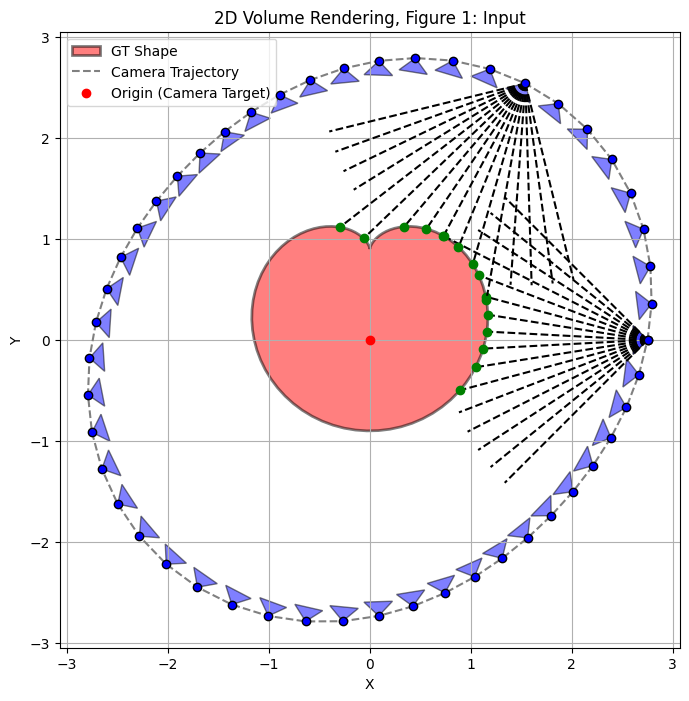

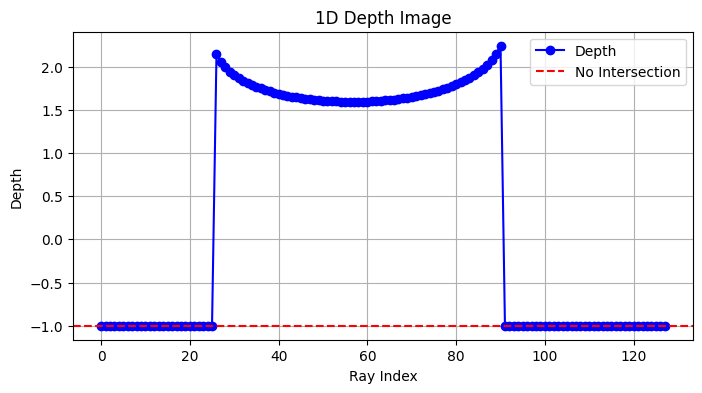

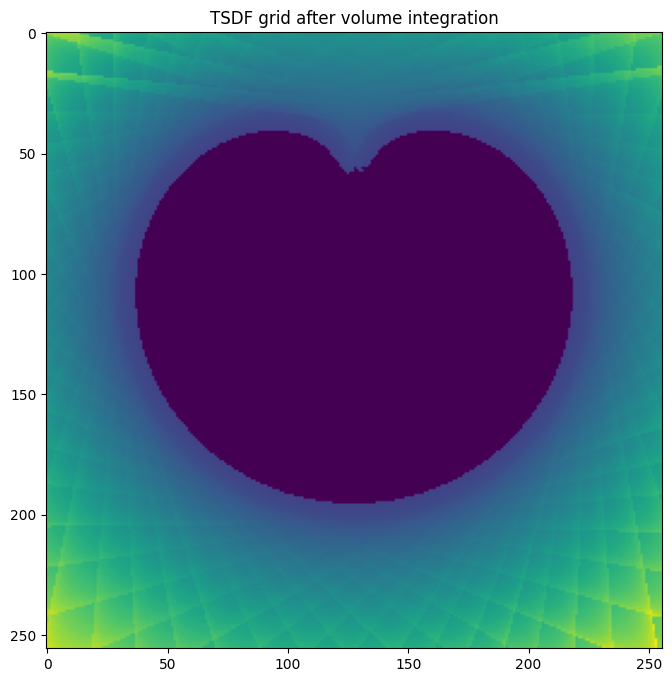

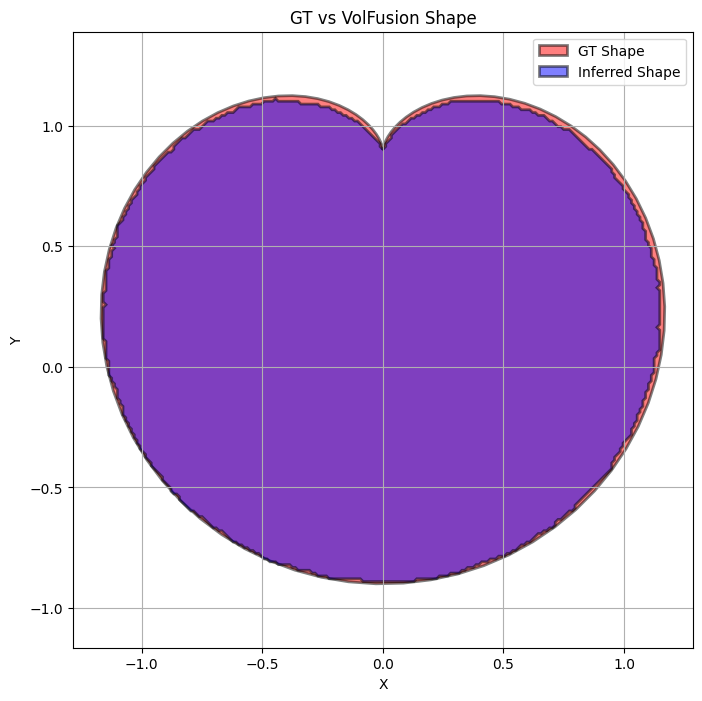

In [2]:

# Stage 1a: Simulate shape, camera trajectory and depth images.  
contour_x, contour_y = generate_heart_contour(max_radius=1.8)
# contour_x, contour_y = generate_pikachu_coutour(max_radius=1.2)

# Generate camera trajectory (for simplicity, we use one camera position)
cameras = generate_camera_trajectory(num_points=50, radius_min = 2.5, radius_max=3)

depth_images = []

# Loop over each camera in the trajectory and compute the depth image
for camera in cameras:
    # Compute the 128-ray depth image for the current camera
    depth_image = compute_depth_image(camera, contour_x, contour_y)    
    # Store the depth image in the list
    depth_images.append(depth_image)

# Stage 1b: Let's visualize our data! 
plt.figure(figsize=(8, 8))
# plot the GT shape
plt.fill(contour_x, contour_y, color='red', alpha=0.5, edgecolor='black', linewidth=2, label="GT Shape")
# plot the camera trajectory
plot_camera_trajectory_with_FOV(cameras['position'])
# Plot 16 sample rays and their intersections with the contour
plot_rays_with_intersections(cameras, 0, contour_x, contour_y)
# Plot 16 sample rays and their intersections with the contour
plot_rays_with_intersections(cameras, 8, contour_x, contour_y)
plt.title("2D Volume Rendering, Figure 1: Input")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid(True)
plt.axis("equal")  # Ensure equal scaling for both axes
plt.show()

# Plot the 128-dimensional depth image
plt.figure(figsize=(8, 4))
plot_depth_image(depth_images[0])


# Stage 2b: Volume integration

# Set hyper-parameters
trunc_threshold = 0.1 # truncation thres
resolution = 256 # resolution of the field. 
grid_range = 1.5 # grid +- range in the normalized units.  

half_resolution = 128

tsdf_grid, weight_map, x_grid, y_grid = initialize_grid(resolution=resolution, grid_range=grid_range)

for i in range(len(cameras)):
    camera = cameras[i]
    depth_image = depth_images[i]
    visibility_mask, ray_indices = check_visibility(camera, x_grid, y_grid)
    # Compute actual depth (distance to each grid point)
    depth_location = np.sqrt((x_grid - camera['position'][0])**2 + (y_grid - camera['position'][1])**2)
    # Get depth for each visible grid point using ray indices
    depth_map = np.zeros_like(depth_location)
    depth_map[visibility_mask] = depth_image[ray_indices[visibility_mask]]

    # Compute SDF for visible points
    sdf = compute_sdf(depth_map, depth_location)
    tsdf_grid, weight_map = update_tsdf(tsdf_grid, weight_map, sdf, visibility_mask, trunc_threshold)

# Post processing to get the final tsdf and shape.
final_tsdf_grid = compute_final_tsdf(tsdf_grid, weight_map)

# Note that I'm using contour extraction here instead of marching cube! 
final_shape = final_tsdf_grid < 0
final_shape = final_shape.astype(np.uint8)*255
contours, _ = cv2.findContours(final_shape, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Normalize the contour from image coordinate to the world coordinate
x_pred = np.float32(contours[0][::-1, :, 0].flatten())
y_pred = np.float32(contours[0][::-1, :, 1].flatten())
x_pred = (x_pred - half_resolution) / half_resolution * 1.5
y_pred = (y_pred - half_resolution) / half_resolution * 1.5


# Stage 2b: Visualize the results for volume integration

# Plot the TSDF field. 
plt.figure(figsize=(8, 8))
plt.title("TSDF grid after volume integration")
plt.imshow(np.flipud(final_tsdf_grid)) # flip to ensure y-up. 

# Plot the final infereed shape vs GT shape
plt.figure(figsize=(8, 8))
# plot the GT shape
plt.fill(contour_x, contour_y, color='red', alpha=0.5, edgecolor='black', linewidth=2, label="GT Shape")
# plot the infereed shape
plt.fill(x_pred, y_pred, color='blue', alpha=0.5, edgecolor='black', linewidth=2, label="Inferred Shape")
plt.title("GT vs VolFusion Shape")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid(True)
plt.axis("equal")  # Ensure equal scaling for both axes
plt.show()

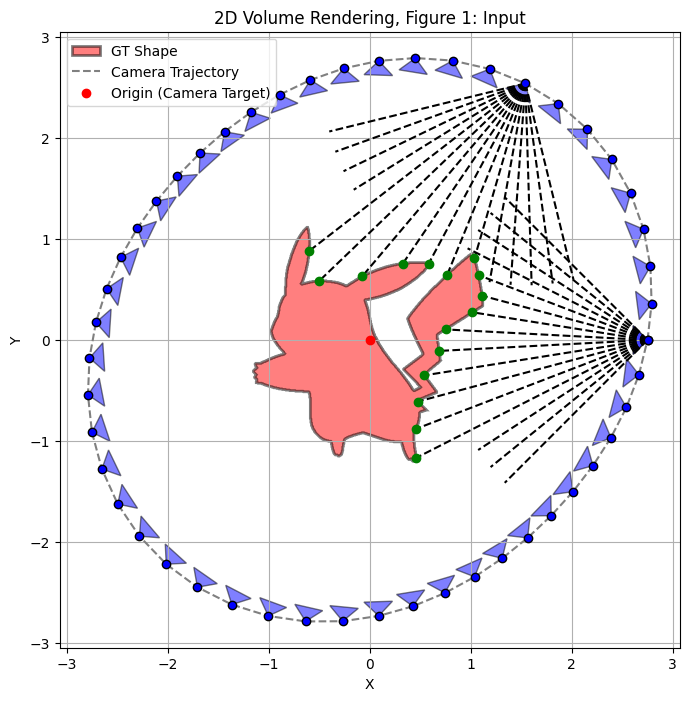

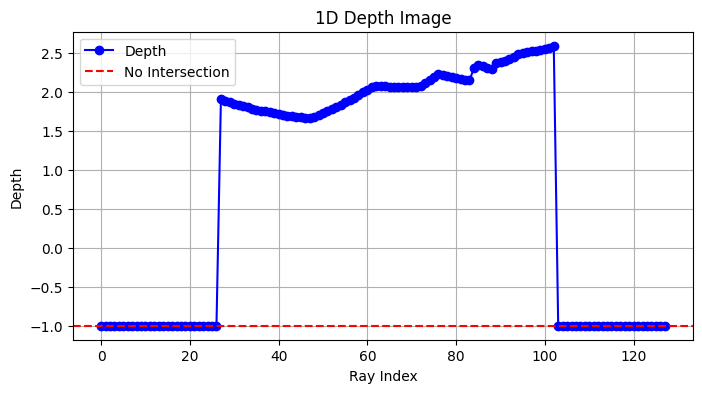

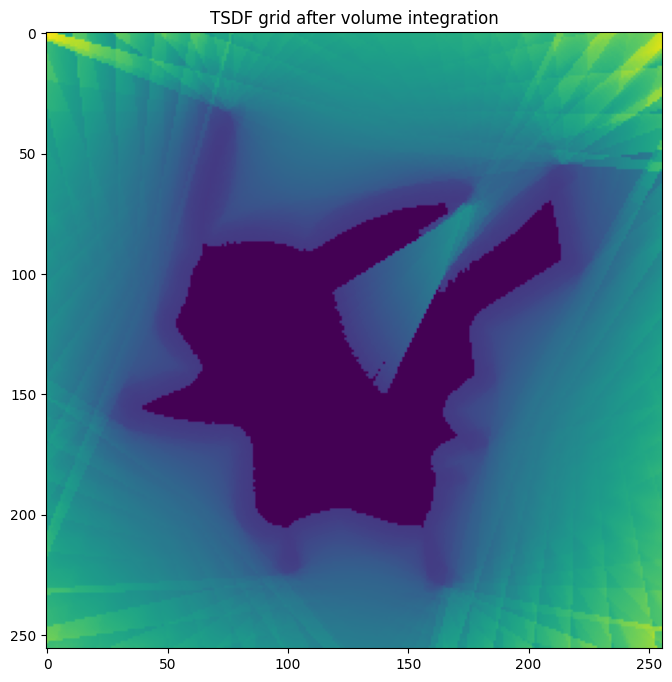

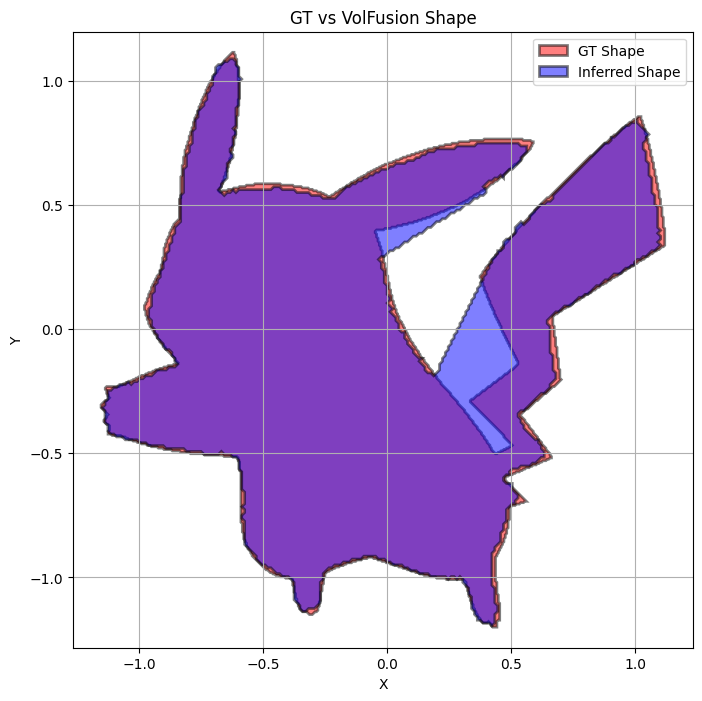

In [5]:
# Stage 1a: Simulate shape, camera trajectory and depth images.  
# contour_x, contour_y = generate_heart_contour(max_radius=1.8)
contour_x, contour_y = generate_pikachu_coutour(max_radius=1.2)

# Generate camera trajectory (for simplicity, we use one camera position)
cameras = generate_camera_trajectory(num_points=50, radius_min = 2.5, radius_max=3)

depth_images = []

# Loop over each camera in the trajectory and compute the depth image
for camera in cameras:
    # Compute the 128-ray depth image for the current camera
    depth_image = compute_depth_image(camera, contour_x, contour_y)    
    # Store the depth image in the list
    depth_images.append(depth_image)

# Stage 1b: Let's visualize our data! 
plt.figure(figsize=(8, 8))
# plot the GT shape
plt.fill(contour_x, contour_y, color='red', alpha=0.5, edgecolor='black', linewidth=2, label="GT Shape")
# plot the camera trajectory
plot_camera_trajectory_with_FOV(cameras['position'])
# Plot 16 sample rays and their intersections with the contour
plot_rays_with_intersections(cameras, 0, contour_x, contour_y)
# Plot 16 sample rays and their intersections with the contour
plot_rays_with_intersections(cameras, 8, contour_x, contour_y)
plt.title("2D Volume Rendering, Figure 1: Input")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid(True)
plt.axis("equal")  # Ensure equal scaling for both axes
plt.show()

# Plot the 128-dimensional depth image
plt.figure(figsize=(8, 4))
plot_depth_image(depth_images[0])


# Stage 2b: Volume integration

# Set hyper-parameters
trunc_threshold = 0.1 # truncation thres
resolution = 256 # resolution of the field. 
grid_range = 1.5 # grid +- range in the normalized units.  

half_resolution = 128

tsdf_grid, weight_map, x_grid, y_grid = initialize_grid(resolution=resolution, grid_range=grid_range)

for i in range(len(cameras)):
    camera = cameras[i]
    depth_image = depth_images[i]
    visibility_mask, ray_indices = check_visibility(camera, x_grid, y_grid)
    # Compute actual depth (distance to each grid point)
    depth_location = np.sqrt((x_grid - camera['position'][0])**2 + (y_grid - camera['position'][1])**2)
    # Get depth for each visible grid point using ray indices
    depth_map = np.zeros_like(depth_location)
    depth_map[visibility_mask] = depth_image[ray_indices[visibility_mask]]

    # Compute SDF for visible points
    sdf = compute_sdf(depth_map, depth_location)
    tsdf_grid, weight_map = update_tsdf(tsdf_grid, weight_map, sdf, visibility_mask, trunc_threshold)

# Post processing to get the final tsdf and shape.
final_tsdf_grid = compute_final_tsdf(tsdf_grid, weight_map)

# Note that I'm using contour extraction here instead of marching cube! 
final_shape = final_tsdf_grid < 0
final_shape = final_shape.astype(np.uint8)*255
contours, _ = cv2.findContours(final_shape, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Normalize the contour from image coordinate to the world coordinate
x_pred = np.float32(contours[0][::-1, :, 0].flatten())
y_pred = np.float32(contours[0][::-1, :, 1].flatten())
x_pred = (x_pred - half_resolution) / half_resolution * 1.5
y_pred = (y_pred - half_resolution) / half_resolution * 1.5


# Stage 2b: Visualize the results for volume integration

# Plot the TSDF field. 
plt.figure(figsize=(8, 8))
plt.title("TSDF grid after volume integration")
plt.imshow(np.flipud(final_tsdf_grid)) # flip to ensure y-up. 

# Plot the final infereed shape vs GT shape
plt.figure(figsize=(8, 8))
# plot the GT shape
plt.fill(contour_x, contour_y, color='red', alpha=0.5, edgecolor='black', linewidth=2, label="GT Shape")
# plot the infereed shape
plt.fill(x_pred, y_pred, color='blue', alpha=0.5, edgecolor='black', linewidth=2, label="Inferred Shape")
plt.title("GT vs VolFusion Shape")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid(True)
plt.axis("equal")  # Ensure equal scaling for both axes
plt.show()